In [1]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
from transvae import trans_models
from transvae.transformer_models import TransVAE
from transvae.rnn_models import RNN, RNNAttn
from transvae.wae_models import WAE
from transvae.aae_models import AAE
from transvae.tvae_util import *
from transvae import analysis

In [2]:
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

import IPython.display as Disp
np.set_printoptions(suppress=True)

This tutorial will demonstrate how to visualize and interpret model memory and how to evaluate model performance on a number of metrics. Full scripts for training models, generating samples and calculating attention weights are provided and instructions on how to use those scripts are included in the README. The functions demonstrated in this tutorial do not have pre-written high throughput scripts but can be used on larger input sizes if desired. 

# Model Reconstruction Performance

A set of metrics on reconstruction accuracy of the different models is presented below. Some parameters need to be selected:
<ul>
    <li>data size: int --how many samples from the data to laod
    <li>data selection: string  --training, testing, full_no_shuffle
    <li>model_src: string --path to model checkpoint
    <li>models : RNN, WAE, AAE, RNNAttn, TransVAE --model selectiong from listed
</ul>

In [27]:
num_sequences =1000
data_selection = "full_no_shuffle"
model_src = "checkpointz/rnn_amp//emb128_latent8//800_rnn-128_peptide.ckpt"
src = 'checkpointz//rnn_amp//emb128_latent8//log_rnn-128_peptide.txt' #src of the loss output file not the model ckpt!
model = RNN(load_fn=model_src)

save_dir= "model_analyses//"+model.name+"_latent_8" #each model will have its own directory
if not os.path.exists(save_dir):os.mkdir(save_dir) 
save_dir= save_dir+"//" #actually enter the folder that was created above

save_df = pd.DataFrame() #this will hold the number variables and save to CSV

gpu = True

if "full_no_shuffle" in data_selection:
    data = pd.read_csv('notebooks//example_data//peptide_combined_no_shuff.txt').to_numpy() 
elif "training" in data_selection:
    data = pd.read_csv('notebooks//example_data//train_test//peptide_train.txt').to_numpy()
elif "testing" in data_selection:
    data = pd.read_csv('notebooks//example_data//train_test//peptide_test.txt').to_numpy()
else:
    data = pd.read_csv('notebooks//example_data//train_test//.txt').to_numpy() 
data_1D = data[:num_sequences,0] #gets rid of extra dimension


C:\Users\s_renaud\Documents\GitHub\MSCSAM_TBD\main_model\transvae\trans_models.py:54: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



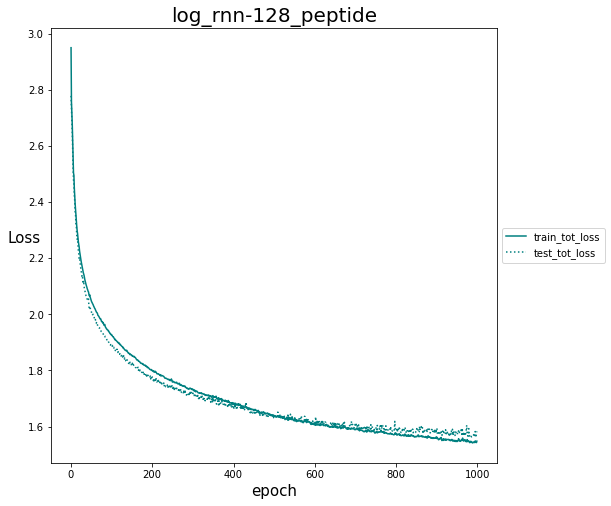

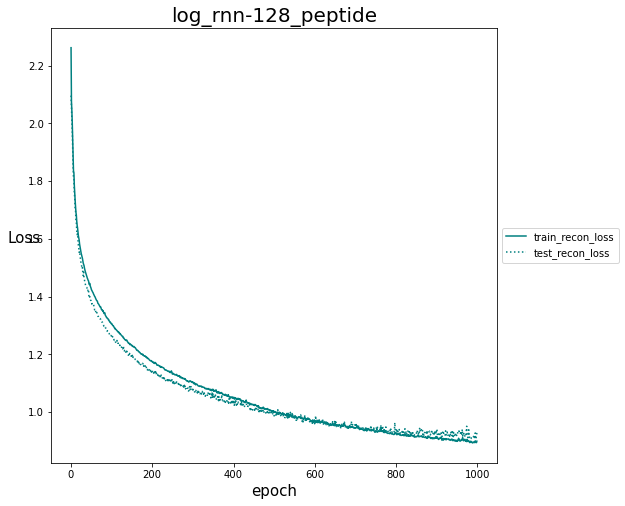

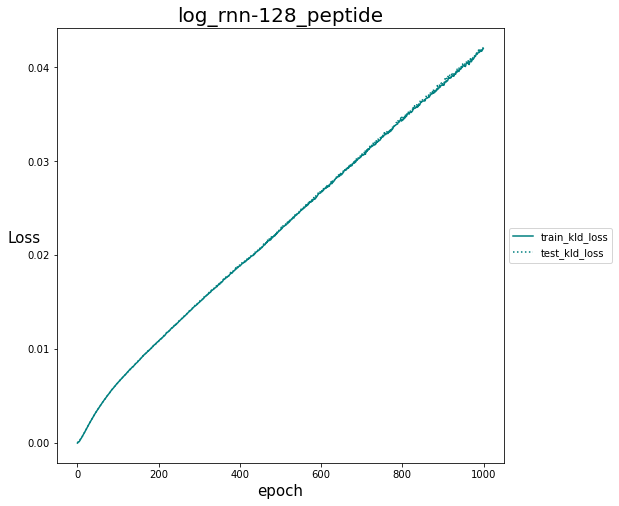

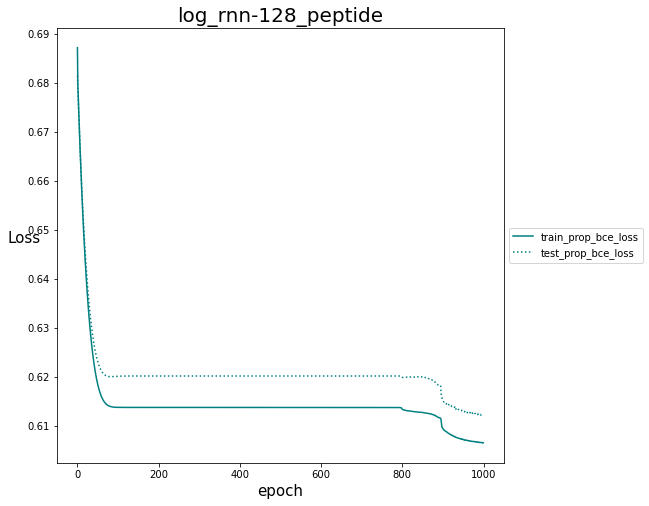

In [26]:
tot_loss = analysis.plot_loss_by_type(src,loss_types=['tot_loss'])
plt.savefig(save_dir+'tot_loss.png')
recon_loss = analysis.plot_loss_by_type(src,loss_types=['recon_loss'])
plt.savefig(save_dir+'recon_loss.png')
kld_loss = analysis.plot_loss_by_type(src,loss_types=['kld_loss'])
plt.savefig(save_dir+'kld_loss.png')
prob_bce_loss = analysis.plot_loss_by_type(src,loss_types=['prop_bce_loss'])
plt.savefig(save_dir+'prob_bce_loss.png')
if 'aae' in src:
    disc_loss = analysis.plot_loss_by_type(src,loss_types=['disc_loss'])
    plt.savefig(save_dir+'disc_loss.png')
if 'wae' in src:
    mmd_loss = analysis.plot_loss_by_type(src,loss_types=['mmd_loss'])
    plt.savefig(save_dir+'mmd_loss.png')

In [28]:
LOAD=False
if LOAD: #this allows loading of reconstructed sequences from a file to save time
    recon_src = 'model_analyses//aae-128_peptide_latent_64_acc//saved_info.csv'
    recon_df = pd.read_csv(recon_src)
    reconstructed_seq = recon_df['reconstructions'].to_list()[:num_sequences]
    props_og = torch.Tensor(recon_df['predicted properties'][:num_sequences])
else:
    model.params['BATCH_SIZE'] = 200 #batch size must match total size of input data
    reconstructed_seq, props = model.reconstruct(data[:num_sequences], log=False, return_mems=False)
    for og_token, reconstructed_token in zip(data_1D, reconstructed_seq):
        print('{} <- Original'.format(og_token))
        print('{} <- Reconstruction'.format(reconstructed_token))
        print('\n')

rnn-128_peptide
cuda
decoding sequences of max length  125 current position:  0
decoding sequences of max length  125 current position:  10
decoding sequences of max length  125 current position:  20
decoding sequences of max length  125 current position:  30
decoding sequences of max length  125 current position:  40
decoding sequences of max length  125 current position:  50
decoding sequences of max length  125 current position:  60
decoding sequences of max length  125 current position:  70
decoding sequences of max length  125 current position:  80
decoding sequences of max length  125 current position:  90
decoding sequences of max length  125 current position:  100
decoding sequences of max length  125 current position:  110
decoding sequences of max length  125 current position:  120
cuda
decoding sequences of max length  125 current position:  0
decoding sequences of max length  125 current position:  10
decoding sequences of max length  125 current position:  20
decoding sequ

In [6]:
training = pd.read_csv('notebooks//example_data//train_test//peptide_train.txt').to_numpy()
train_idx_list = [np.where(data==training[idx][0]) for idx in range(len(training))]

testing = pd.read_csv('notebooks//example_data//train_test//peptide_test.txt').to_numpy()
test_idx_list = [np.where(data==testing[idx][0]) for idx in range(len(testing))]

In [7]:
test=False
train=True
if test:
    batch_recon_len = len(reconstructed_seq)
    reconstructed_seq = [reconstructed_seq[test_idx_list[i][0][0]] for i in range(len(test_idx_list)) if test_idx_list[i][0][0]<batch_recon_len]
    data_1D= [data_1D[test_idx_list[i][0][0]] for i in range(len(test_idx_list)) if test_idx_list[i][0][0]<batch_recon_len]
    props = [props[test_idx_list[i][0][0]] for i in range(len(test_idx_list)) if test_idx_list[i][0][0]<batch_recon_len]
    props=torch.Tensor(props)
    data = testing[:][0]
    true_props_data = pd.read_csv('notebooks//example_data//function_full_no_shuff.txt').to_numpy()
    true_props = true_props_data[0:num_sequences,0]
    true_props= [true_props[test_idx_list[i][0][0]] for i in range(len(test_idx_list)) if test_idx_list[i][0][0]<batch_recon_len]
if train:
    batch_recon_len = len(reconstructed_seq)
    reconstructed_seq = [reconstructed_seq[train_idx_list[i][0][0]] for i in range(len(train_idx_list)) if train_idx_list[i][0][0]<batch_recon_len]
    data_1D= [data_1D[train_idx_list[i][0][0]] for i in range(len(train_idx_list)) if train_idx_list[i][0][0]<batch_recon_len]
    props = [props[train_idx_list[i][0][0]] for i in range(len(train_idx_list)) if train_idx_list[i][0][0]<batch_recon_len]
    props=torch.Tensor(props)
    data = training[:][0]
    true_props_data = pd.read_csv('notebooks//example_data//function_full_no_shuff.txt').to_numpy()
    true_props = true_props_data[0:num_sequences,0]
    true_props= [true_props[train_idx_list[i][0][0]] for i in range(len(train_idx_list)) if train_idx_list[i][0][0]<batch_recon_len]

In [29]:
if gpu:
    torch.cuda.empty_cache() #free allocated CUDA memory

In [30]:
save_df['reconstructions'] = reconstructed_seq #placing the saves on a line separate from the ops allows for editing
save_df['predicted properties'] = [prop.item() for prop in props[:len(reconstructed_seq)]]

<ul>MCC info:
    <li>+1 represents a perfect prediction
    <li>0 no better than random prediction
    <li>−1 indicates total disagreement between prediction and observation.
</ul>

In [31]:
true_props_data = pd.read_csv('notebooks//example_data//function_full_no_shuff.txt').to_numpy()
true_props = true_props_data[0:num_sequences,0]
prop_acc, prop_conf, MCC=calc_property_accuracies(props[:len(reconstructed_seq)],true_props[:len(reconstructed_seq)], MCC=True)

property accuracy : 0 / 1000 = 0.0
MCC:  Data error Division by zero


In [37]:
for item in zip(props[:len(reconstructed_seq)],true_props[:len(reconstructed_seq)]):
    print (item)

(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0

(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0.3036]), 1)
(tensor([0

In [10]:
save_df['property prediction accuracy'] = prop_acc
save_df['property prediction confidence'] = prop_conf
save_df['MCC'] = MCC

Token accuracies are accuracies per token, 
<ul>
    <li>sequence accuracies are accuracies per sequence
    <li>token accuracies are accuracies for each token averaged over all tokens in input dataset
    <li>position accuracies are per sequence position

In [11]:
# First we tokenize the input and reconstructed smiles
input_sequences = []
for seq in data_1D:
    input_sequences.append(peptide_tokenizer(seq))
output_sequences = []
for seq in reconstructed_seq:
    output_sequences.append(peptide_tokenizer(seq))

In [12]:
seq_accs, tok_accs, pos_accs, seq_conf, tok_conf, pos_conf  = calc_reconstruction_accuracies(input_sequences, output_sequences)

C:\Users\s_renaud\Documents\GitHub\MSCSAM_TBD\main_model\transvae\tvae_util.py:215: RuntimeWarning: invalid value encountered in double_scalars
  position_acc.append(position_accs[0,i] / position_accs[1,i])


In [13]:
save_df['sequence accuracy'] = seq_accs
save_df['sequence confidence'] = seq_conf
save_df['token accuracy'] = tok_accs
save_df['token confidence'] = tok_conf

save_df = pd.concat([pd.DataFrame({'position_accs':pos_accs,'position_confidence':pos_conf }), save_df], axis=1)

Plotting the accuracy on token position

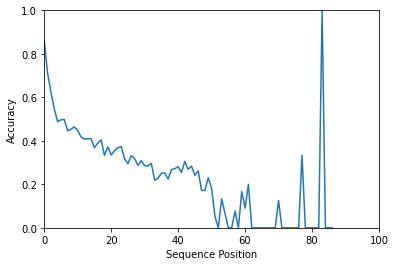

In [14]:
plt.plot(pos_accs)
plt.ylim((0,1))
plt.xlim(0,100)
plt.xlabel('Sequence Position')
plt.ylabel('Accuracy')
plt.savefig(save_dir+'token_position_accuracy.png')
plt.show()

# Visualizing Model Memory

The memory of a model is analogous to the probability distribution of molecular embeddings that it has learned during training. A single molecular embedding is the size 128 vector at the center of the variational bottleneck. Each model has a built-in method for calculating and returning the model memory for a set of input structures, `calc_mems()`. ***(note - we plot the mean vector rather than the reparameterized vector so we can identify and analyze the meaningful latent dimensions)***

In [16]:
if model.model_type =='aae':
    mus, _, _ = model.calc_mems(data[:], log=False, save=False) 
elif model.model_type == 'wae':
    mus, _, _ = model.calc_mems(data[:], log=False, save=False) 
else:
    mems, mus, logvars = model.calc_mems(data[:], log=False, save=False) #subset size 1200*35=42000 would be ok

rnn-128_peptide


Shannon information entropy

In [17]:
from transvae.tvae_util import *

In [18]:
#save the list of entropies for each latent dim
vae_entropy_mus = calc_entropy(mus)
save_df = pd.concat([save_df,pd.DataFrame({'mu_entropies':vae_entropy_mus})], axis=1)
if model.model_type != 'wae' and model.model_type!= 'aae': #these don't have a variational type bottleneck
    vae_entropy_mems  = calc_entropy(mems)
    save_df = pd.concat([save_df,pd.DataFrame({'mem_entropies':vae_entropy_mems})], axis=1)
    vae_entropy_logvars = calc_entropy(logvars)
    save_df = pd.concat([save_df,pd.DataFrame({'logvar_entropies':vae_entropy_logvars})], axis=1)

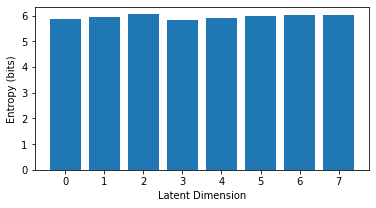

In [19]:
fig = plt.figure(figsize=(6,3))

plt.bar(range(len(vae_entropy_mus)), vae_entropy_mus)
plt.xlabel('Latent Dimension')
plt.ylabel('Entropy (bits)')
plt.savefig(save_dir+'mem_entropy')

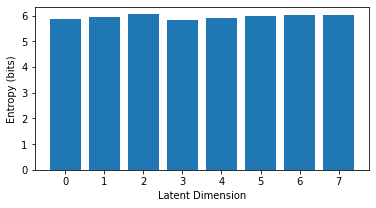

In [20]:
if model.model_type != 'wae' and model.model_type!= 'aae':
    fig = plt.figure(figsize=(6,3))
    plt.bar(range(len(vae_entropy_mems)), vae_entropy_mems)
    plt.xlabel('Latent Dimension')
    plt.ylabel('Entropy (bits)')
    plt.savefig(save_dir+'mu_entropy')

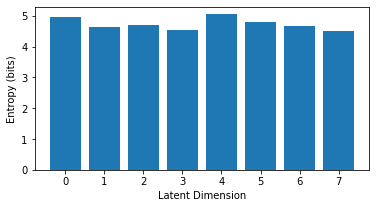

In [21]:
if model.model_type != 'wae' and model.model_type!= 'aae':
    fig = plt.figure(figsize=(6,3))
    plt.bar(range(len(vae_entropy_logvars)), vae_entropy_logvars)
    plt.xlabel('Latent Dimension')
    plt.ylabel('Entropy (bits)')
    plt.savefig(save_dir+'logvar_entropy')

We can see that some dimensions have significantly more information contained across the 25 samples than others and they correspond with the selective memory visualization shown above. We can sum the entropy of all dimensions to find the full model entropy. Again, note that we would need a larger sample size to converge the model entropy.

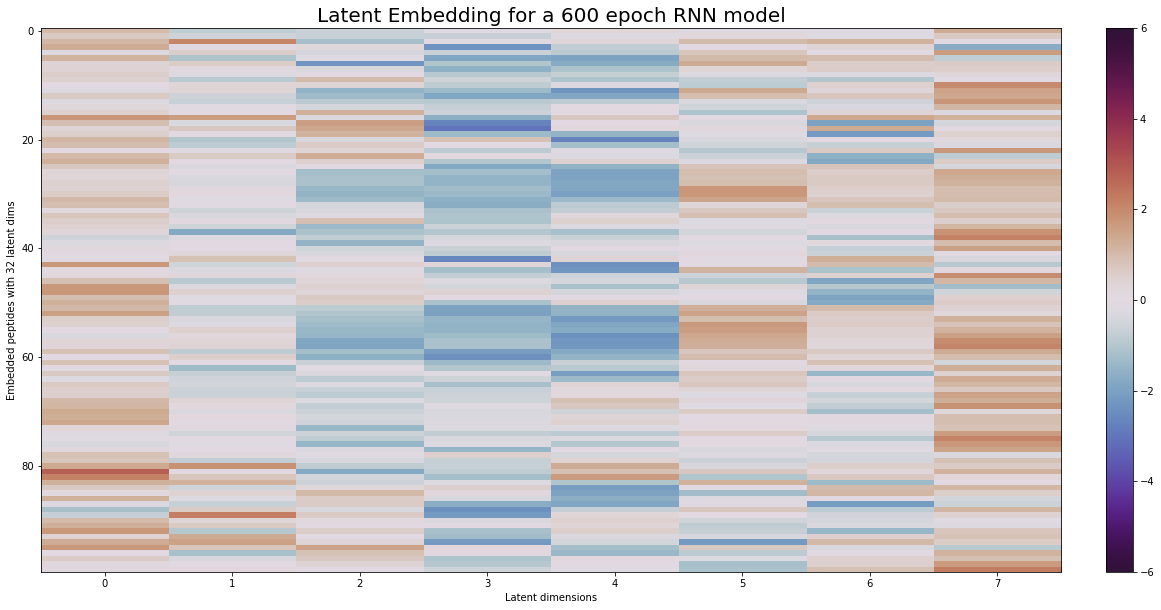

In [22]:
fig = plt.figure(figsize=(20,10))
plt.imshow(mus[:100], vmin=-6, vmax=6, aspect='auto', cmap='twilight_shifted')
plt.rc('font', size=10)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.xticks()
plt.yticks()
plt.ylabel("Embedded peptides with 32 latent dims", )
plt.xlabel("Latent dimensions")
plt.title('Latent Embedding for a 600 epoch RNN model')
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()
plt.imsave(save_dir+'mus.png', mus[:100], dpi=50)

<h4>Evaluate the trustworthiness of the mapping from raw input data to latent space manifold

In [23]:
flattened_data = data[:,0]
max_len = 126
char_dict = model.params['CHAR_DICT']
input_sequences = []
for seq in flattened_data:
    tokenized = (peptide_tokenizer(seq))
    input_sequences.append(encode_seq(tokenized, max_len, char_dict))
raw_input=input_sequences

In [25]:
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.manifold import trustworthiness
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import plotly.express as px

#create random index and re-index ordered memory list creating n random sub-lists (ideally resulting in IID random lists)
random_idx = np.random.permutation(np.arange(stop=mus.shape[0]))
mus[:] = mus[random_idx]
data = data[random_idx]

subsample_start=0
subsample_length=mus.shape[0] #this may change depending on batch size

#(for length based coloring): record all peptide lengths iterating through input
pep_lengths = []
for idx, pep in enumerate(data[subsample_start:(subsample_start+subsample_length)]):
    pep_lengths.append( len(pep[0]) )   
#(for function based coloring): pull function from csv with peptide functions
s_to_f =pd.read_csv("data//peptides//amp_function//sequence_function_link_std_only.csv")    
function = s_to_f["Antimicrobial"][subsample_start:(subsample_start+subsample_length)]
function = function[random_idx] #account for random permutation

pca = PCA(n_components=4)
pca_batch =pca.fit_transform(X=mus[:])

fig = px.scatter_matrix(pca_batch, color= pep_lengths, opacity=0.8)
fig.write_image(save_dir+'pca_length.png', width=1200, height=800)

fig = px.scatter_matrix(pca_batch, color= [str(itm) for itm in function], opacity=0.8)
fig.write_image(save_dir+'pca_function.png', width=1200, height=800)
print('done images')
#create n subsamples and calculate silhouette score for each
latent_mem_func_subsamples = []
pca_func_subsamples = []
n=20
for s in range(n):
    s_len = len(mus)//n #sample lengths
    mem_func_sil = metrics.silhouette_score(mus[s_len*s:s_len*(s+1)], function[s_len*s:s_len*(s+1)], metric='euclidean')
    latent_mem_func_subsamples.append(mem_func_sil)
    XY = [i for i in zip(pca_batch[s_len*s:s_len*(s+1),0], pca_batch[s_len*s:s_len*(s+1),1])]
    pca_func_sil = metrics.silhouette_score(XY, function[s_len*s:s_len*(s+1)], metric='euclidean')
    pca_func_subsamples.append(pca_func_sil)
save_df = pd.concat([save_df,pd.DataFrame({'latent_mem_func_silhouette':latent_mem_func_subsamples})], axis=1)
save_df = pd.concat([save_df,pd.DataFrame({'pca_func_silhouette':pca_func_subsamples})], axis=1)

done images


KeyboardInterrupt: 

<h4>Trustworthiness, Continuity, Steadiness, Cohesiveness </h4>

In [7]:
import coranking #coranking.readthedocs.io
from coranking.metrics import trustworthiness, continuity, LCMC
from transvae.snc import SNC #github.com/hj-n/steadiness-cohesiveness

trust_subsamples = []
cont_subsamples = []
lcmc_subsamples = []
steadiness_subsamples = []
cohesiveness_subsamples = []

n=35
parameter = { "k": 50,"alpha": 0.1 } #for steadiness and cohesiveness
for s in range(n):
    s_len = len(mus)//n #sample lengths
    Q = coranking.coranking_matrix(mus[s_len*s:s_len*(s+1)], pca_batch[s_len*s:s_len*(s+1)])
    trust_subsamples.append( np.mean(trustworthiness(Q, min_k=1, max_k=50)) )
    cont_subsamples.append( np.mean(continuity(Q, min_k=1, max_k=50)) )
    lcmc_subsamples.append( np.mean(LCMC(Q, min_k=1, max_k=50)) )
    print(n,trust_subsamples[s],cont_subsamples[s],lcmc_subsamples[s])
    
    metrics = SNC(raw=mus[s_len*s:s_len*(s+1)], emb=pca_batch[s_len*s:s_len*(s+1)], iteration=300, dist_parameter=parameter)
    metrics.fit() #solve for steadiness and cohesiveness
    steadiness_subsamples.append(metrics.steadiness())
    cohesiveness_subsamples.append(metrics.cohesiveness())
    print(metrics.steadiness(),metrics.cohesiveness())
    Q=0 #trying to free RAM
    metrics=0
    torch.cuda.empty_cache() #free allocated CUDA memory
    
save_df = pd.concat([save_df,pd.DataFrame({'latent_to_PCA_trustworthiness':trust_subsamples})], axis=1)
save_df = pd.concat([save_df,pd.DataFrame({'latent_to_PCA_continuity':cont_subsamples})], axis=1)
save_df = pd.concat([save_df,pd.DataFrame({'latent_to_PCA_lcmc':lcmc_subsamples})], axis=1)
save_df = pd.concat([save_df,pd.DataFrame({'latent_to_PCA_steadiness':steadiness_subsamples})], axis=1)
save_df = pd.concat([save_df,pd.DataFrame({'latent_to_PCA_cohesiveness':cohesiveness_subsamples})], axis=1)

35 0.9323371070392994 0.955943644657873 0.30235160829993696
0.8221535993883174 0.8221251532645236
35 0.9347386322735322 0.9564338211415729 0.300052145836256
0.8293241042858411 0.8332322015610817
35 0.9347216481019782 0.9574598117268456 0.297529626758199


KeyboardInterrupt: 

In [24]:
save_df.to_csv(save_dir+"saved_info.csv", index=False)